In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from numpy.linalg import norm
import pickle
import joblib
import sys
sys.path.append('../../../src/models')
from clustering import consensus_signatures

## Plotting function

In [2]:
def plot_centroid_column(column, df_index, title_text, output_path, cluster_sil_data):
    mutation_colors = {
        "C>A": [3 / 256, 189 / 256, 239 / 256],
        "C>G": [1 / 256, 1 / 256, 1 / 256],
        "C>T": [228 / 256, 41 / 256, 38 / 256],
        "T>A": [203 / 256, 202 / 256, 202 / 256],
        "T>C": [162 / 256, 207 / 256, 99 / 256],
        "T>G": [236 / 256, 199 / 256, 197 / 256],
    }

    mutation_types = df_index.to_list()
    substitutions = [mut.split('[')[1].split(']')[0] for mut in mutation_types]
    flanking_bases = [mut.replace(f'[{sub}]', '') for mut, sub in zip(mutation_types, substitutions)]

    ordered_indices = sorted(range(len(mutation_types)), key=lambda i: ["C>A", "C>G", "C>T", "T>A", "T>C", "T>G"].index(substitutions[i]))
    x_positions = np.arange(len(ordered_indices))
    bar_colors = [mutation_colors[substitutions[i]] for i in ordered_indices]

    fig, ax = plt.subplots(figsize=(13, 4), dpi=500)
    ax.grid(axis='y', alpha=0.5, color='lightgrey', linewidth=0.5, zorder=1)

    # Ensure y_values are ordered according to ordered_indices and convert to percentage
    # The 'column' Series is reordered using .iloc[ordered_indices] and then converted to a NumPy array with .values
    y_values_for_plot = column.iloc[ordered_indices].values * 100
    
    ax.bar(x_positions, y_values_for_plot, width=0.5, color=bar_colors, alpha=0.8, zorder=2)

    # ymax calculation should use the reordered values that are actually plotted
    # If all values in y_values_for_plot are 0, y_values_for_plot.max() will be 0, leading to ymax = 0.
    # This would cause ax.set_ylim(0, 0), which might impact subsequent calculations using ax.get_ylim().
    ymax = y_values_for_plot.max() * 1.1
    ax.set_ylim(0, ymax)

    unique_subs = ["C>A", "C>G", "C>T", "T>A", "T>C", "T>G"]
    group_positions = {sub: [] for sub in unique_subs}
    # Correctly populate group_positions with the new x_positions (i)
    for i, original_idx in enumerate(ordered_indices):
        substitution_type = substitutions[original_idx]
        group_positions[substitution_type].append(i)

    y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
    for i, idx in enumerate(ordered_indices):
        flank = flanking_bases[idx]
        sub = substitutions[idx]
        # Note: If y_range is 0 (due to ymax being 0), the y-offsets for text will also be 0.
        five_prime_flank_y_pos = ax.get_ylim()[0] - (y_range/15)
        ref_y_pos = ax.get_ylim()[0] - (y_range/30)
        three_prim_flank_y_pos = ax.get_ylim()[0] - (y_range/200)
        ax.text(i, five_prime_flank_y_pos, flank[0], ha='center', va='top', rotation=90, fontsize=8, color="grey")
        ax.text(i, ref_y_pos, sub[0], ha='center', va='top', rotation=90, fontsize=8, color=mutation_colors[sub], fontweight='bold')
        ax.text(i, three_prim_flank_y_pos, flank[1], ha='center', va='top', rotation=90, fontsize=8, color="grey", clip_on=False)

    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
    ax.set_xlim(-0.5, len(mutation_types) - 0.5)
    ax.set_xticks([])
    ax.set_ylabel("Percentage of Single Base Substitutions", fontsize=9)

    ax.spines['top'].set_color("lightgrey")
    ax.spines['right'].set_color("lightgrey")
    ax.spines['left'].set_color("lightgrey")
    ax.spines['bottom'].set_color("lightgrey")

    ax.tick_params(axis='y', colors='grey', width=0.5)
    plt.yticks(fontsize=8)
    ax.set_yticklabels([f"{tick:.1f}%" for tick in ax.get_yticks()])

    for sub_key in unique_subs:
        if group_positions[sub_key]: # Ensure the list of positions is not empty
            min_x, max_x = min(group_positions[sub_key]), max(group_positions[sub_key])
            rect_color = mutation_colors[sub_key]
            # Note: If ax.get_ylim()[1] (i.e., ymax) is 0, rectangle y-position and height will be 0.
            ax.add_patch(plt.Rectangle((min_x, ax.get_ylim()[1] * 1.03), max_x - min_x, ax.get_ylim()[1]* 0.05,
                                color=rect_color, clip_on=False))
            ax.text((min_x + max_x) / 2, ax.get_ylim()[1] * 1.1, sub_key, ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

    ax.text(0.01, 0.95, title_text, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
    
    cluster_letter = title_text.replace("SBS96", "")
    cluster_index = ord(cluster_letter) - ord('A')
    cluster_info = cluster_sil_data[cluster_index]
    ax.text(0.99, 0.95, f"avg silouette={cluster_info['avg_sil']:.3f}, min silouette={cluster_info['min_sil']:.3f}",
            transform=ax.transAxes, fontsize=10, va='top', ha='right')

    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()
    plt.close()


## Read input matrix to use the SBS96 MutationType index

In [3]:
df = pd.read_csv("../../../data/processed/BRCA.SBS96.all", sep="\t")

# 2. Drop the "MutationType" column
feature_names = df["MutationType"].tolist()
df_matrix = df.drop(columns=["MutationType"])
sample_ids = list(df_matrix.columns)

X = df_matrix.to_numpy()
X

array([[0, 3, 0, ..., 1, 1, 0],
       [1, 3, 3, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 2, 1, ..., 2, 0, 0]], shape=(96, 789))

## 4 centroids, of signatures extracted at k=4

In [ ]:
file_path = "S_4.txt"
centroids_np = np.loadtxt(file_path, delimiter='\t')

## You can investigate the 100 replicates of this extraction at k=4

In [ ]:
file = 'nmf_replicates_k4.joblib'
data = None
with open(file, 'rb') as f:
    data = joblib.load(f)
    print(data['S_all'].shape)
    print(data['A_all'].shape)

(100, 96, 4)
(100, 4, 789)


## Read the centroid signature matrix as dataframe

In [6]:
# Determine the number of columns after transposition
num_cols = centroids_np.shape[1]
print(num_cols)
# Create column names
column_names = [f"SBS96{chr(65 + i)}" for i in range(num_cols)]

# Turn the transposed NumPy array into a Pandas DataFrame
centroids_df = pd.DataFrame(centroids_np, index=df["MutationType"], columns=column_names)

centroids_df

4


,SBS96A,SBS96B,SBS96C,SBS96D
MutationType,,,,
A[C>A]A,0.000934,0.000032,0.007635,0.019347
A[C>A]C,0.000576,0.000249,0.013495,0.023530
A[C>A]G,0.000078,0.000839,0.003225,0.007645
A[C>A]T,0.000038,0.001862,0.004578,0.013830
A[C>G]A,0.001430,0.000065,0.001453,0.018618
...,...,...,...,...
T[T>C]T,0.000093,0.010482,0.004099,0.007297
T[T>G]A,0.000087,0.000009,0.000858,0.006014
T[T>G]C,0.000271,0.000934,0.002113,0.005484


## Compare with the SigProfilerExtractor result of k=4 —> examine if cosine similarity > 0.95

Download from https://drive.google.com/drive/u/0/folders/1Mvj3BmzoAc3UgthSErNhEgCRi653-H4U

In [ ]:
tsv_file_path = "/Users/zichenjiang/Downloads/SBS96_arivoli/All_Solutions/SBS96_4_Signatures/Signatures/SBS96_S4_Signatures.txt" 
signatures_df = pd.read_csv(tsv_file_path, sep="\t").set_index('MutationType')

def calculate_best_matches(our_result_df, sigprofiler_df):
    # Align on MutationType index
    our_result_df = our_result_df.loc[our_result_df.index.intersection(sigprofiler_df.index)]
    sigprofiler_df = sigprofiler_df.loc[our_result_df.index]

    best_pairs = []
    for our_col in our_result_df.columns:
        best_score = None
        best_pair = None
        for sig_col in sigprofiler_df.columns:
            x = our_result_df[our_col].values
            y = sigprofiler_df[sig_col].values
            l1 = np.sum(np.abs(x - y))
            l2 = np.sqrt(np.sum((x - y) ** 2))
            cosine = np.dot(x, y) / (norm(x) * norm(y))
            score = {'Our_Signature': our_col, 'SigProfiler_Signature': sig_col,
                     'L1_Norm': l1, 'L2_Norm': l2, 'Cosine_Similarity': cosine}
            if best_score is None or (
                l1 < best_score['L1_Norm'] and l2 < best_score['L2_Norm'] and cosine > best_score['Cosine_Similarity']
            ):
                best_score = score
                best_pair = (our_col, sig_col)
        best_pairs.append(best_score)
    return pd.DataFrame(best_pairs)

# Align row index to MutationType
aligned_centroids_df = centroids_df.reindex(signatures_df.index)
aligned_signatures_df = signatures_df.reindex(aligned_centroids_df.index)

# Compute and print best matching signature pairs
results_df = calculate_best_matches(aligned_centroids_df, aligned_signatures_df)
print("Best matching pairs between our signatures and SigProfiler signatures:")
print(results_df)

Best matching pairs between our signatures and SigProfiler signatures:
  Our_Signature SigProfiler_Signature   L1_Norm   L2_Norm  Cosine_Similarity
0        SBS96A                SBS96A  0.045890  0.015315           0.999143
1        SBS96B                SBS96D  0.040473  0.007491           0.999277
2        SBS96C                SBS96B  0.113553  0.031070           0.993163
3        SBS96D                SBS96C  0.054687  0.008451           0.997627


## Parse the stabilities of our centroids

In [8]:
import re

text_data = """Cluster 0: avg_sil=0.942, min_sil=0.859
Cluster 1: avg_sil=0.994, min_sil=0.939
Cluster 2: avg_sil=0.495, min_sil=0.191
Cluster 3: avg_sil=-0.240, min_sil=-0.712
Cluster 4: avg_sil=0.920, min_sil=0.424
Cluster 5: avg_sil=0.088, min_sil=-0.298"""

cluster_sil_data = {}
pattern = re.compile(r"Cluster (\d+): avg_sil=([-\d.]+), min_sil=([-\d.]+)")

for line in text_data.strip().split('\n'):
    match = pattern.match(line)
    if match:
        cluster_id = int(match.group(1))
        avg_sil = float(match.group(2))
        min_sil = float(match.group(3))
        cluster_sil_data[cluster_id] = {'avg_sil': avg_sil, 'min_sil': min_sil}


In [9]:
cluster_sil_data

{0: {'avg_sil': 0.942, 'min_sil': 0.859},
 1: {'avg_sil': 0.994, 'min_sil': 0.939},
 2: {'avg_sil': 0.495, 'min_sil': 0.191},
 3: {'avg_sil': -0.24, 'min_sil': -0.712},
 4: {'avg_sil': 0.92, 'min_sil': 0.424},
 5: {'avg_sil': 0.088, 'min_sil': -0.298}}

## Plot

/var/folders/jk/ltpq08_128l0byf2mw4yytv40000gn/T/ipykernel_20956/123090237.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.1f}%" for tick in ax.get_yticks()])


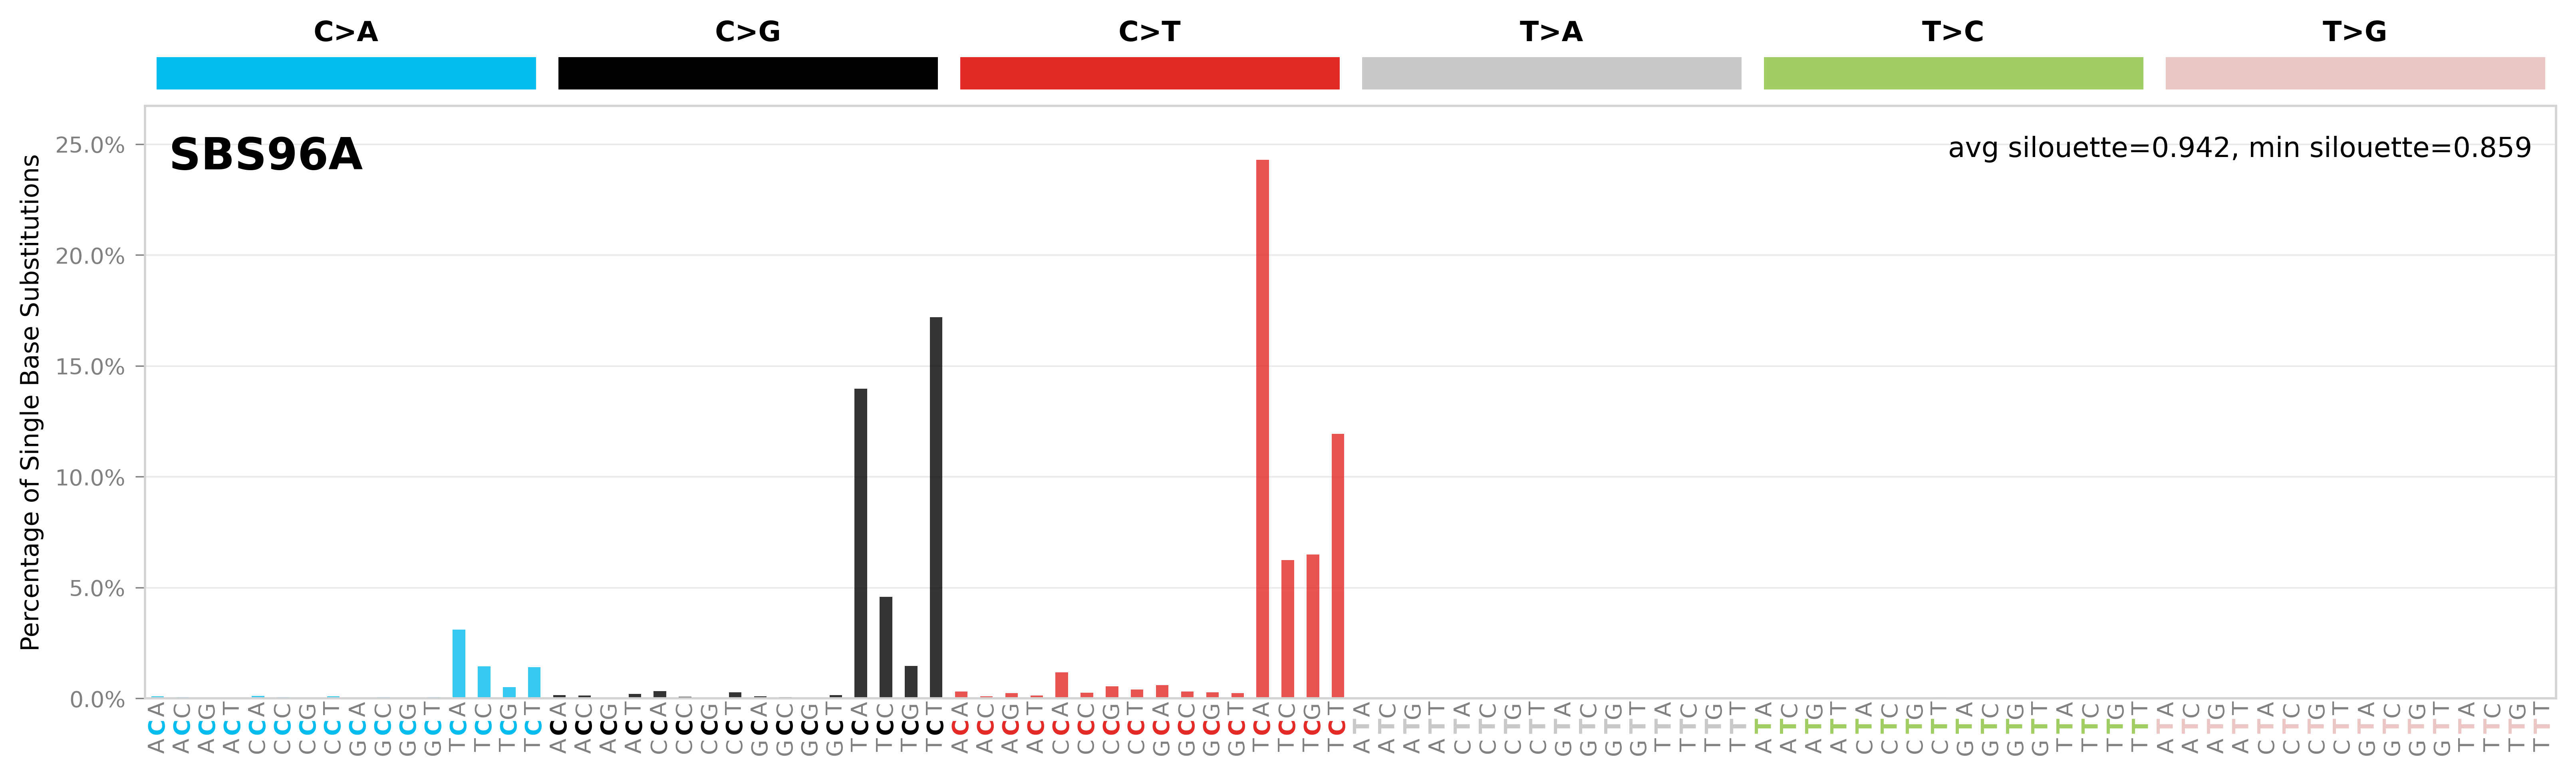

/var/folders/jk/ltpq08_128l0byf2mw4yytv40000gn/T/ipykernel_20956/123090237.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.1f}%" for tick in ax.get_yticks()])


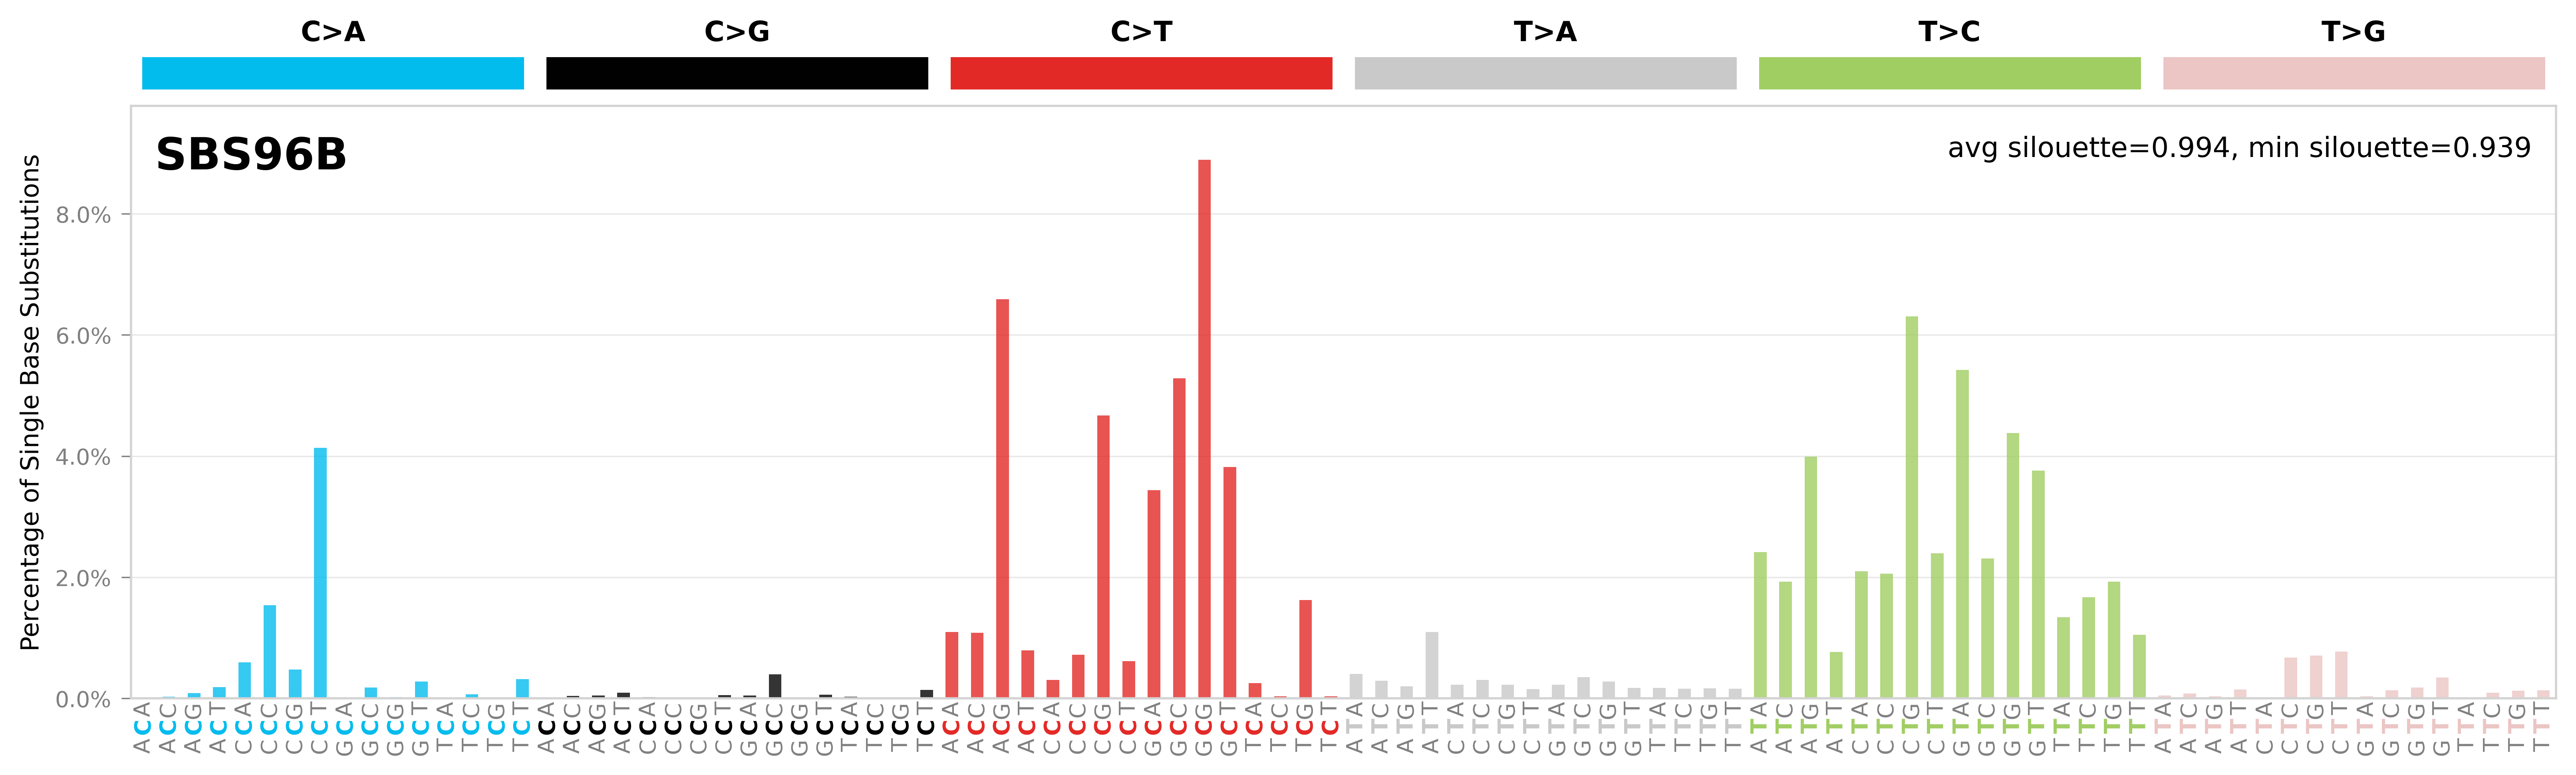

/var/folders/jk/ltpq08_128l0byf2mw4yytv40000gn/T/ipykernel_20956/123090237.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.1f}%" for tick in ax.get_yticks()])


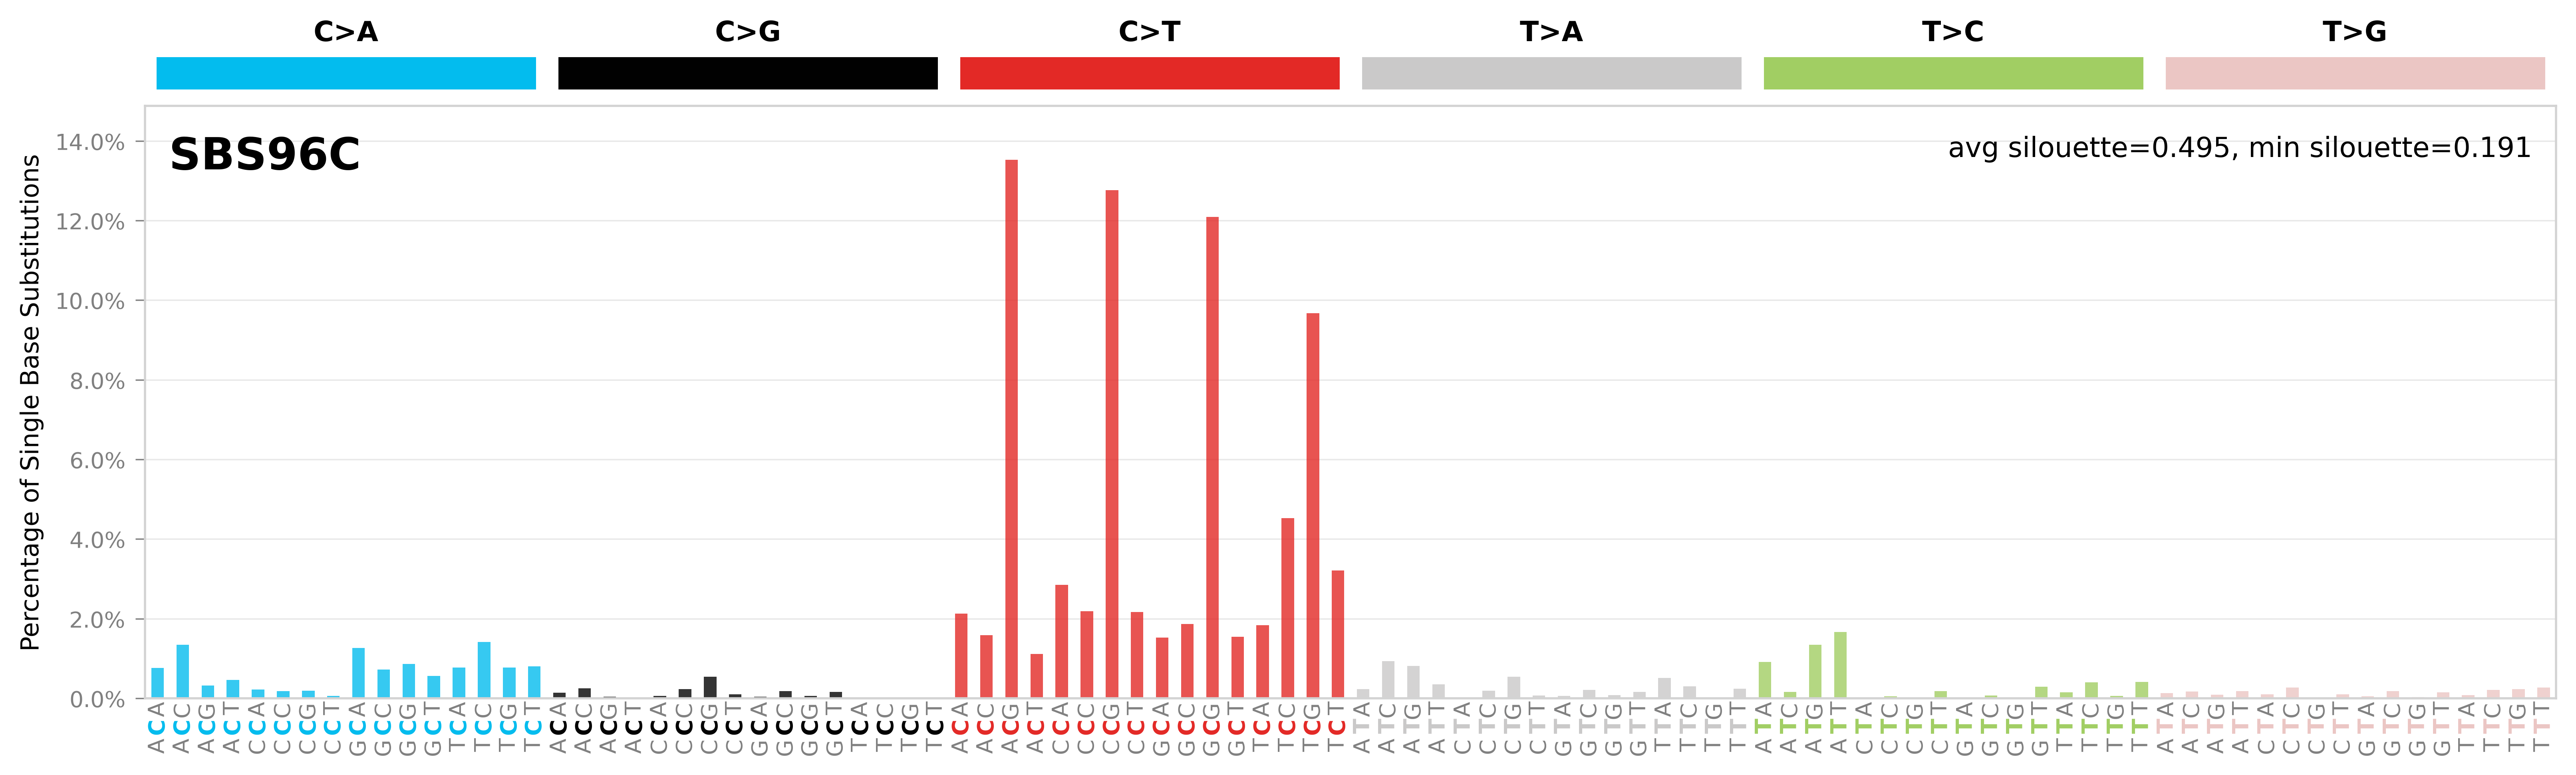

/var/folders/jk/ltpq08_128l0byf2mw4yytv40000gn/T/ipykernel_20956/123090237.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{tick:.1f}%" for tick in ax.get_yticks()])


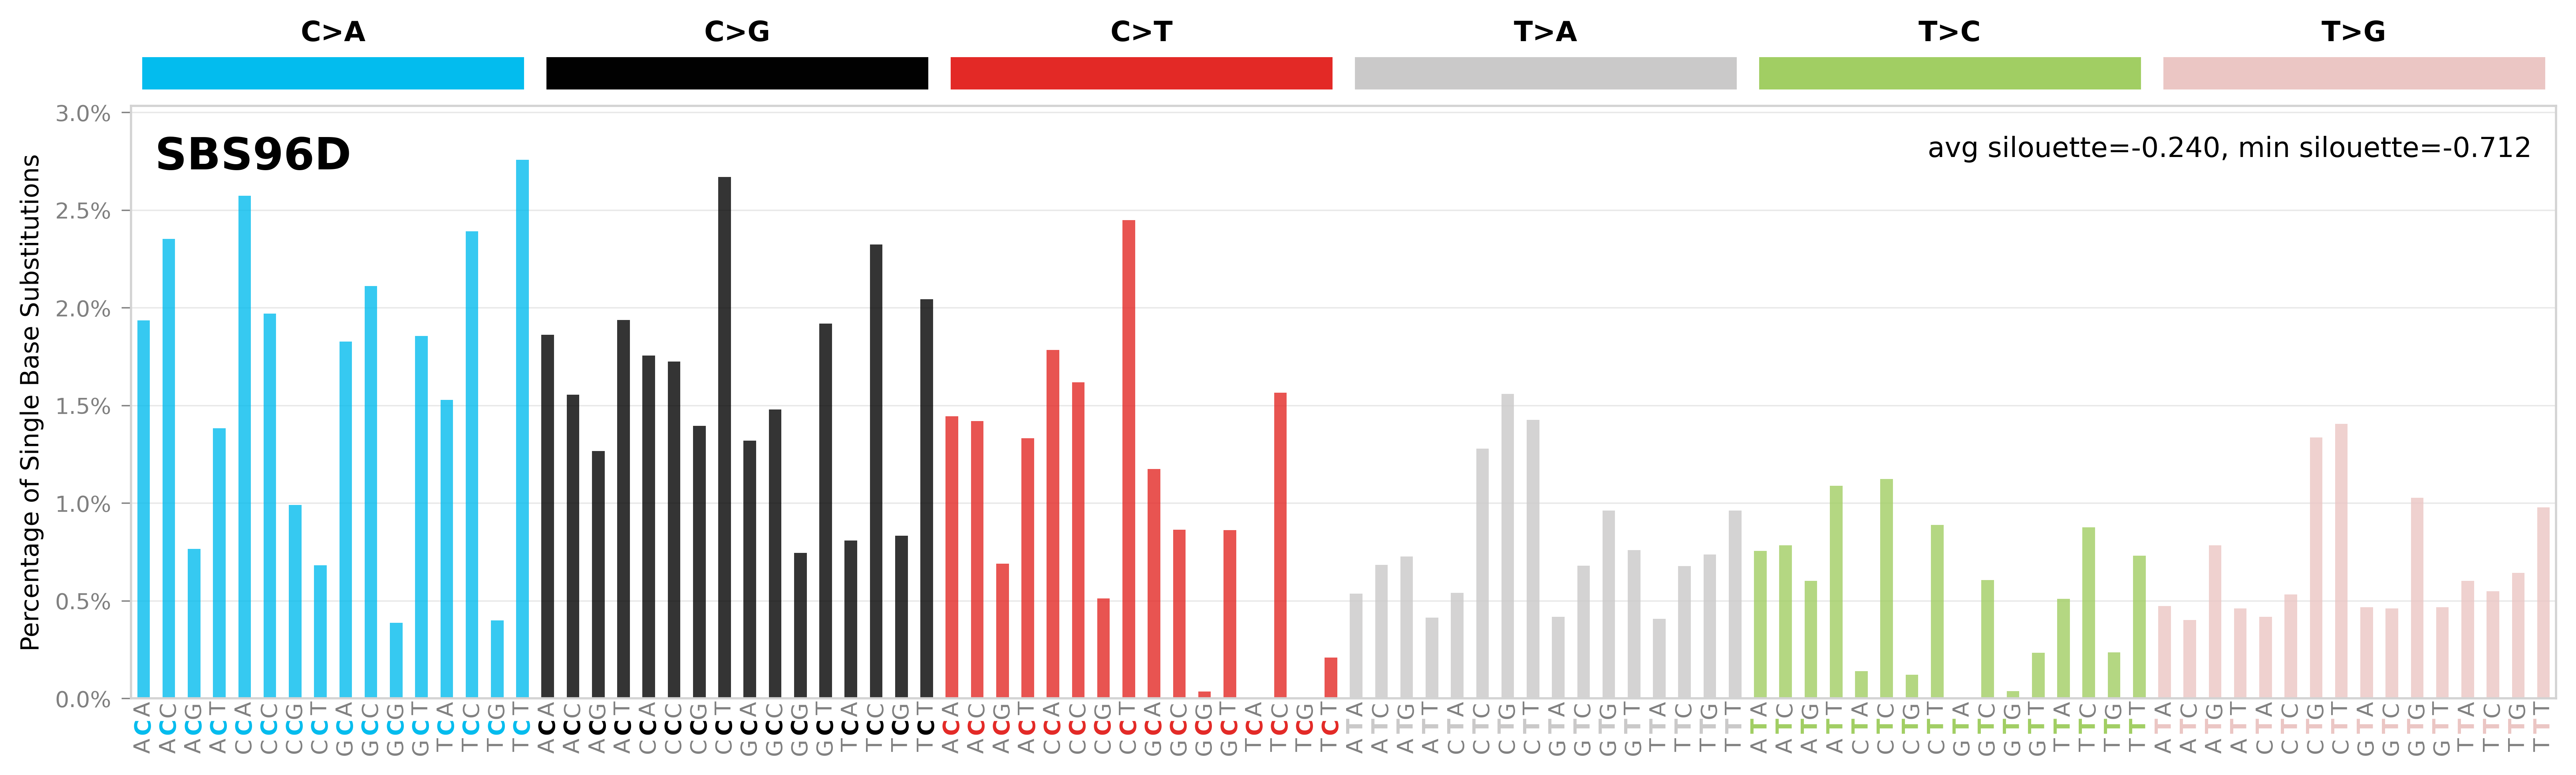

Centroid plots saved to: /Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-3/notebooks/personal/cardiff/


In [10]:
# Assuming centroids_df is your DataFrame
output_dir = "/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-3/notebooks/personal/cardiff/"
os.makedirs(output_dir, exist_ok=True)


# Example cluster silhouette data (replace with your actual data)
# cluster_sil_data = {
#     0: {'avg_sil': 0.965, 'min_sil': 0.890},
#     1: {'avg_sil': 0.996, 'min_sil': 0.992},
#     2: {'avg_sil': 0.973, 'min_sil': 0.899},
#     # Add more clusters as needed
# }


for i, column_name in enumerate(centroids_df.columns):
    output_filename = os.path.join(output_dir, f"centroid_{column_name}.png")
    plot_centroid_column(centroids_df[column_name], centroids_df.index, f"SBS96{chr(65 + i)}", output_filename, cluster_sil_data)
print(f"Centroid plots saved to: {output_dir}")
